# 💰 Sesión 03: Optimización y Dinero

## 📑 Índice
1.  [Carga y Preparación de Datos](#1.-Carga-y-Preparación-de-Datos) 📦
2.  [Optuna: El Francotirador](#2.-Optuna:-El-Francotirador) 🎯
3.  [Calibración de Probabilidades](#3.-Calibración:-¿Confías-en-tu-modelo?) ⚖️
4.  [Profit Curves: Hablando en Dólares](#4.-Profit-Curves:-Hablando-en-Dólares) 💰
5.  [Conclusión y Siguientes Pasos](#5.-Conclusión) 🏁

---

## 💼 Caso de Negocio: Maximizar el ROI
**Contexto:** Eres el Lead Data Scientist en "Financiera Futuro". Tu modelo de Credit Scoring (Sesión 01 y 02) ya tiene un buen AUC. Pero el Gerente de Riesgos te dice: *"No me importa el AUC, me importa cuánto dinero ganamos o perdemos"*.

**El Problema:** Un modelo con AUC 0.90 puede ser menos rentable que uno de 0.85 si falla en los clientes de alto valor. Además, usar los hiperparámetros por defecto de LightGBM es como conducir un Ferrari en primera marcha.

**Tu Misión:**
1.  **Tunear el Motor:** Usar **Optuna** para encontrar la configuración óptima de LightGBM automáticamente.
2.  **Traducir a Dinero:** Crear una **Profit Curve** para decidir el punto de corte (threshold) que maximiza la ganancia del banco, no solo la precisión técnica.

## 🎯 Objetivos de Aprendizaje
1.  **Optimización Bayesiana:** Entender por qué GridSearch es cosa del pasado y cómo Optuna encuentra mejores hiperparámetros en menos tiempo.
2.  **Calibración:** Asegurar que un "80% de probabilidad" signifique realmente un 80% de riesgo.
3.  **Business Analytics:** Conectar la Matriz de Confusión con el Estado de Resultados (P&L) y encontrar el umbral óptimo de decisión.

In [1]:
# 📦 Librerías y Configuración

import warnings
from sklearn import set_config
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import lightgbm as lgb
import optuna
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../../"))
from recursos.utils import load_data

# Data manipulation

# Visualización

# Optimización


# Pipeline y Preprocesamiento (estilo producción - Sesión 01)

# Utilidades del curso

# Configuración para que sklearn devuelva DataFrames
set_config(transform_output="pandas")

# Constantes del Dataset
TARGET_COL = "target_y"
COLS_TO_DROP = [TARGET_COL, "malo_sf_inicio",
                "periodo", "Unnamed: 0", "Unnamed__0"]
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Configuración visual
axis_font = {"family": "DejaVu Sans", "size": 11}
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = axis_font["family"]
plt.rcParams["font.size"] = axis_font["size"]

# Menos ruido en la consola
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Implementación de calibration_curve (compatible con todas las versiones de sklearn)


def calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform"):
    """
    Calcula la curva de calibración.

    Parameters:
    -----------
    y_true : array-like - Etiquetas reales (0 o 1)
    y_prob : array-like - Probabilidades predichas
    n_bins : int - Número de bins para agrupar probabilidades
    strategy : str - 'uniform' (bins equidistantes) o 'quantile' (mismo # de muestras por bin)

    Returns:
    --------
    prob_true : array - Fracción real de positivos por bin
    prob_pred : array - Probabilidad media predicha por bin
    """
    y_true = np.asarray(y_true, dtype=float)
    y_prob = np.asarray(y_prob, dtype=float)

    if y_true.shape[0] != y_prob.shape[0]:
        raise ValueError("y_true y y_prob deben tener la misma longitud")
    if strategy not in {"uniform", "quantile"}:
        raise ValueError("strategy debe ser 'uniform' o 'quantile'")

    if strategy == "quantile":
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.quantile(y_prob, quantiles)
        bins[0], bins[-1] = 0.0, 1.0
        bins = np.unique(bins)
    else:
        bins = np.linspace(0, 1, n_bins + 1)

    bin_ids = np.digitize(y_prob, bins[1:-1], right=True)

    prob_true = []
    prob_pred = []
    for b in range(len(bins) - 1):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        prob_true.append(y_true[mask].mean())
        prob_pred.append(y_prob[mask].mean())

    return np.array(prob_true), np.array(prob_pred)


print("✅ Librerías importadas correctamente.")

c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas correctamente.


## 📂 1. Carga y Preparación de Datos

Usaremos el mismo dataset de **Credit Scoring** de las sesiones anteriores. El objetivo es predecir si una empresa caerá en *default* (impago).

### 📂 Diccionario de Datos (Credit Scoring)
Estamos trabajando con un dataset real de **Riesgo de Crédito para Empresas**.

**Variables Clave:**
*   `target_y`: **Variable Objetivo**. 1 = Cliente Incumplidor (Bad), 0 = Cliente Cumplidor (Good).
*   `banca`, `sector_final`: Segmentación del cliente (Categóricas).
*   `NumeroTrabajadores`: Tamaño de la empresa.
*   `MAX_PORC_DEUDA...`: Variables de comportamiento financiero en el sistema.
*   `EF_...`: Variables de Estados Financieros (Ratios de liquidez, rotación, etc.).

In [2]:
# Cargar datos usando la utilidad centralizada del curso
df = load_data('credit_scoring.csv')

# Limpiamos nombres de columnas para evitar caracteres especiales que LightGBM no acepta
original_cols = df.columns.tolist()
df = df.rename(columns=lambda c: re.sub(r"[^0-9A-Za-z_]+", "_", c))
if df.columns.tolist() != original_cols:
    print("🔧 Columnas renombradas para ser compatibles con LightGBM.")

print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📋 Columnas: {df.columns.tolist()[:8]}...")
print(f"🎯 Tasa de default: {df[TARGET_COL].mean():.2%}")
df.head()


🔧 Columnas renombradas para ser compatibles con LightGBM.
📊 Dimensiones del dataset: (7180, 30)
📋 Columnas: ['Unnamed_0', 'banca', 'tipocredito', 'sector_final', 'tipocontribuyente', 'NumeroTrabajadores', 'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M', 'MAX_CNT_ENTIDADES_SSFF_06M']...
🎯 Tasa de default: 24.48%


,Unnamed_0,banca,tipocredito,sector_final,tipocontribuyente,NumeroTrabajadores,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M,MAX_CNT_ENTIDADES_SSFF_06M,SD_MAX_DIAS_MORA_SSFF_06M,CAT_ENTFIN_PRINCIPAL_01M,...,EF_VAR_INMUEBLE_MAQ_EQUIPO_2a,EF_DIF_PROMEDIO_PAGOS_DIAS_2a,EF_ROTACION_INVENTARIOS_1a,EF_COBERTURA_SERVICIO_DEUDA_1a,EF_ActivosCirculante_PasivoCirculante_1a,EF_Cajasbancos_PasivoExigible_1a,EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a,malo_sf_inicio,target_y,periodo
0,1,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.829708,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201803
1,2,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.898718,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201804
2,3,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.970726,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201805
3,4,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.224903,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201806
4,5,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,11.303392,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201808


In [3]:
# 🧹 Preprocesamiento Robusto con Pipeline (Estilo Producción - Sesión 01)
# Aplicamos el enfoque profesional: sin Data Leakage, reproducible y mantenible.

# ✅ SOLUCIÓN ANTI-PATTERN 3 (IDs como Features):
# Eliminamos explícitamente columnas que no aportan valor predictivo.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

# ✅ SOLUCIÓN ANTI-PATTERN 1 (Data Leakage):
# Dividimos en Train/Test ANTES de calcular cualquier estadística.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print(f"📊 Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(
    f"📈 Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")

# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(
    include=['object', 'category']).columns.tolist()

print(f"\n🔢 Features numéricas ({len(num_features)}): {num_features[:5]}...")
print(
    f"🏷️ Features categóricas ({len(cat_features)}): {cat_features if cat_features else 'Ninguna'}")

# Pipeline Numérico: Imputación con mediana + Escalado
num_pipeline = Pipeline([
    # ✅ El imputer calculará la mediana SOLO con X_train durante el .fit()
    ('imputer', SimpleImputer(strategy='median')),
    # ✅ SOLUCIÓN ANTI-PATTERN 4 (Olvido del Escalado):
    ('scaler', StandardScaler())
])

# Pipeline Categórico: Imputación + Target Encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(min_samples_leaf=10))
])

# ColumnTransformer (El Router)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features) if cat_features else ('cat', 'drop', [])
    ],
    verbose_feature_names_out=False,
    remainder='drop'
)

# Aplicar preprocesamiento (fit solo en train - evita data leakage)
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\n✅ Preprocesamiento aplicado:")
print(f"   X_train procesado: {X_train_processed.shape}")
print(f"   X_test procesado: {X_test_processed.shape}")
print(f"   Nulos restantes: {X_train_processed.isnull().sum().sum()}")


📊 Train shape: (5744, 27), Test shape: (1436, 27)
📈 Distribución target (Train): {0: 0.7552228412256268, 1: 0.24477715877437325}

🔢 Features numéricas (22): ['Unnamed_0', 'NumeroTrabajadores', 'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M', 'MAX_CNT_ENTIDADES_SSFF_06M', 'SD_MAX_DIAS_MORA_SSFF_06M']...
🏷️ Features categóricas (5): ['banca', 'tipocredito', 'sector_final', 'tipocontribuyente', 'CAT_PRODUCTOS_SSFF_01M']

✅ Preprocesamiento aplicado:
   X_train procesado: (5744, 27)
   X_test procesado: (1436, 27)
   Nulos restantes: 0


## 🎯 2. Optuna: El Francotirador

En lugar de probar combinaciones al azar (RandomSearch) o todas las combinaciones (GridSearch), **Optuna** usa la historia de las pruebas anteriores para decidir cuál es el siguiente mejor conjunto de hiperparámetros a probar.

### ¿Cómo funciona la Optimización Bayesiana?
1.  **Objective Function**: Una función que recibe `trial` (un intento), entrena el modelo y devuelve una métrica (ej. AUC).
2.  **Study**: El objeto que orquesta la optimización (maximizar o minimizar la métrica).
3.  **Pruning (Poda)**: Si un entrenamiento va mal a la mitad, Optuna lo corta para ahorrar tiempo.
4.  **TPE (Tree-structured Parzen Estimator)**: El algoritmo que "aprende" qué regiones del espacio de hiperparámetros son más prometedoras.

### ⚠️ Real-World Warning: GridSearch vs Optuna
En producción, **GridSearch es inviable** para modelos con muchos hiperparámetros:
*   Un LightGBM tiene ~15 hiperparámetros importantes.
*   Si probamos 5 valores por cada uno: $5^{15} = 30$ mil millones de combinaciones.
*   Optuna típicamente encuentra mejores resultados en **50-100 trials** (minutos vs años).

In [4]:
def objective(trial):
    """
    Función objetivo para Optuna.
    Entrena un modelo LightGBM con los hiperparámetros sugeridos y retorna el AUC.
    """
    # 1. Definir el espacio de búsqueda
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        # Regularización L1 y L2
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        # Arquitectura del árbol
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # Sampling (para reducir overfitting)
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # Learning rate
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }

    # 2. Crear el dataset de LightGBM (con datos preprocesados)
    dtrain = lgb.Dataset(X_train_processed, label=y_train)

    # 3. Cross-Validation dentro de la optimización (más robusto que un simple train/test)
    cv_results = lgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=3,
        stratified=True,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        seed=RANDOM_STATE
    )

    # 4. Retornar el mejor score (el último de la lista de validación)
    best_auc = cv_results['valid auc-mean'][-1]
    return best_auc


# Crear el estudio de optimización
study = optuna.create_study(direction='maximize')

# Ejecutar optimización (20 trials para el ejemplo, en producción usar 50-100)
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n🎉 ¡Optimización terminada!")
print(f"🏆 Mejor AUC (CV): {study.best_value:.4f}")
print(f"⚙️ Mejores parámetros:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.977958:   5%|▌         | 1/20 [00:05<01:53,  5.98s/it]

Early stopping, best iteration is:
[585]	valid's auc: 0.977958 + 0.00277332
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.977958:  10%|█         | 2/20 [00:09<01:19,  4.40s/it]

Early stopping, best iteration is:
[370]	valid's auc: 0.9749 + 0.00385695
Training until validation scores don't improve for 50 rounds


Best trial: 2. Best value: 0.980464:  15%|█▌        | 3/20 [00:17<01:46,  6.24s/it]

Early stopping, best iteration is:
[607]	valid's auc: 0.980464 + 0.00183161
Training until validation scores don't improve for 50 rounds


Best trial: 2. Best value: 0.980464:  20%|██        | 4/20 [00:21<01:24,  5.28s/it]

Early stopping, best iteration is:
[419]	valid's auc: 0.972719 + 0.00268542
Training until validation scores don't improve for 50 rounds


Best trial: 4. Best value: 0.982172:  25%|██▌       | 5/20 [00:28<01:26,  5.77s/it]

Early stopping, best iteration is:
[512]	valid's auc: 0.982172 + 0.0012082
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  30%|███       | 6/20 [00:34<01:21,  5.84s/it]

Early stopping, best iteration is:
[359]	valid's auc: 0.983714 + 0.00121199
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  35%|███▌      | 7/20 [00:38<01:07,  5.22s/it]

Early stopping, best iteration is:
[292]	valid's auc: 0.981321 + 0.000863967
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  40%|████      | 8/20 [00:48<01:21,  6.83s/it]

Early stopping, best iteration is:
[910]	valid's auc: 0.979626 + 0.00186042
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  45%|████▌     | 9/20 [00:55<01:16,  6.97s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.951702 + 0.00184439
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  50%|█████     | 10/20 [00:59<01:00,  6.06s/it]

Early stopping, best iteration is:
[392]	valid's auc: 0.979059 + 0.00212033
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  55%|█████▌    | 11/20 [01:11<01:09,  7.73s/it]

Did not meet early stopping. Best iteration is:
[999]	valid's auc: 0.975152 + 0.00175794
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  60%|██████    | 12/20 [01:19<01:03,  7.90s/it]

Early stopping, best iteration is:
[399]	valid's auc: 0.981297 + 0.000973238
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  65%|██████▌   | 13/20 [01:25<00:52,  7.46s/it]

Did not meet early stopping. Best iteration is:
[995]	valid's auc: 0.91146 + 0.00508416
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  70%|███████   | 14/20 [01:30<00:39,  6.60s/it]

Early stopping, best iteration is:
[312]	valid's auc: 0.981147 + 0.00177788
Training until validation scores don't improve for 50 rounds


Best trial: 5. Best value: 0.983714:  75%|███████▌  | 15/20 [01:40<00:37,  7.54s/it]

Did not meet early stopping. Best iteration is:
[989]	valid's auc: 0.978048 + 0.0018939
Training until validation scores don't improve for 50 rounds


Best trial: 15. Best value: 0.984415:  80%|████████  | 16/20 [01:44<00:26,  6.61s/it]

Early stopping, best iteration is:
[192]	valid's auc: 0.984415 + 0.00154296
Training until validation scores don't improve for 50 rounds


Best trial: 15. Best value: 0.984415:  85%|████████▌ | 17/20 [01:55<00:23,  7.93s/it]

Early stopping, best iteration is:
[887]	valid's auc: 0.981529 + 0.00136741
Training until validation scores don't improve for 50 rounds


Best trial: 15. Best value: 0.984415:  90%|█████████ | 18/20 [02:00<00:13,  7.00s/it]

Early stopping, best iteration is:
[265]	valid's auc: 0.982673 + 0.00121628
Training until validation scores don't improve for 50 rounds


Best trial: 15. Best value: 0.984415:  95%|█████████▌| 19/20 [02:03<00:05,  5.76s/it]

Early stopping, best iteration is:
[173]	valid's auc: 0.980336 + 0.00152641
Training until validation scores don't improve for 50 rounds


Best trial: 15. Best value: 0.984415: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]

Early stopping, best iteration is:
[618]	valid's auc: 0.976264 + 0.00175166

🎉 ¡Optimización terminada!
🏆 Mejor AUC (CV): 0.9844
⚙️ Mejores parámetros:
   lambda_l1: 0.00011009692764854484
   lambda_l2: 1.1639489305642075e-07
   num_leaves: 192
   min_child_samples: 17
   feature_fraction: 0.7484956264530774
   bagging_fraction: 0.873970704111831
   bagging_freq: 4
   learning_rate: 0.11927496273519461


### 📊 Visualizando la Optimización
Optuna tiene visualizaciones increíbles para entender qué pasó.

In [5]:
# Historia de la optimización: ¿Mejoramos con el tiempo?
optuna.visualization.plot_optimization_history(study)


In [6]:
# Importancia de Hiperparámetros: ¿Qué movió la aguja?
optuna.visualization.plot_param_importances(study)


## ⚖️ 3. Calibración: ¿Confías en tu modelo?

Un modelo puede tener AUC 0.90 pero estar **descalibrado**:
- Si el modelo dice "Probabilidad de Default = 20%", esperamos que de 100 clientes con ese score, **exactamente 20** caigan en default.
- Si caen 40, el modelo está **subestimando el riesgo** (peligroso 🚨).
- Si caen 5, el modelo está **sobreestimando el riesgo** (perdemos oportunidades de negocio 💸).

### ⚠️ Real-World Warning: Probabilidades Distorsionadas
Al usar `class_weight='balanced'` o técnicas de oversampling (SMOTE), las probabilidades que predice el modelo estarán **distorsionadas**:
*   **Efecto:** Las probabilidades serán más altas de lo real.
*   **Solución:** Si el negocio necesita saber la probabilidad exacta de impago (ej. para calcular la tasa de interés), debes aplicar **Calibración de Probabilidades** usando `CalibratedClassifierCV`.

### Entrenemos el modelo final con los mejores parámetros

In [7]:
# Entrenar modelo final con los mejores hiperparámetros de Optuna
best_params = study.best_params
model = lgb.LGBMClassifier(
    **best_params,
    n_estimators=500,
    verbosity=-1,
    random_state=RANDOM_STATE
)
model.fit(X_train_processed, y_train)

# ✅ SOLUCIÓN ANTI-PATTERN 5 (Evaluar en Train):
# Evaluamos SIEMPRE sobre el conjunto de TEST (datos que el modelo nunca vio)
y_prob = model.predict_proba(X_test_processed)[:, 1]
auc_test = roc_auc_score(y_test, y_prob)

print(f"✅ Modelo final entrenado con los mejores hiperparámetros")
print(f"📊 AUC en Test: {auc_test:.4f}")
print(f"📈 Mejora vs AUC CV: {auc_test - study.best_value:+.4f}")


✅ Modelo final entrenado con los mejores hiperparámetros
📊 AUC en Test: 0.9930
📈 Mejora vs AUC CV: +0.0085


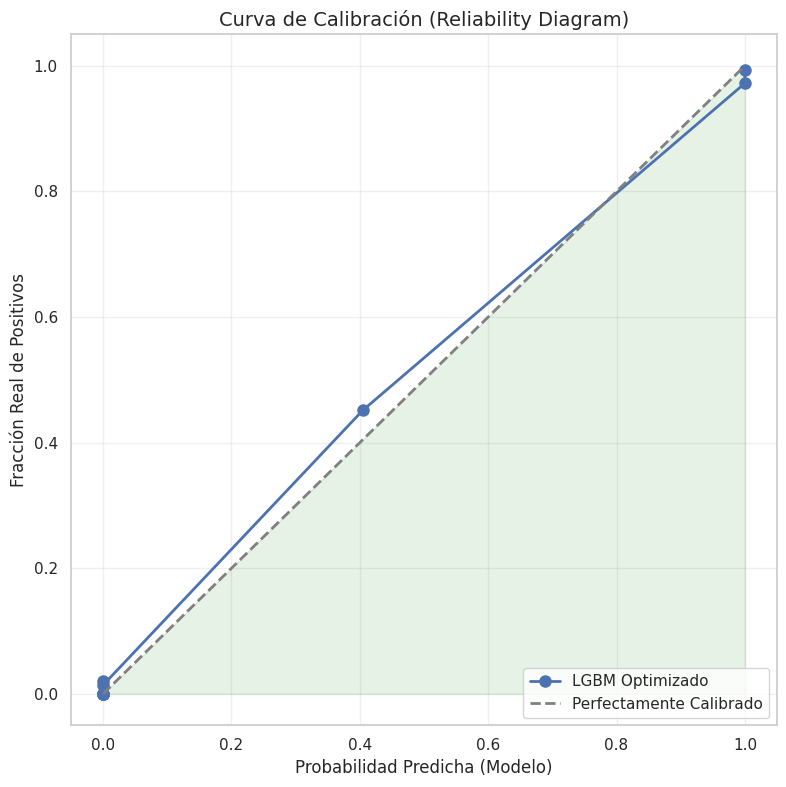

📏 Brier Score: 0.0298 (menor es mejor, 0 = perfecto)


In [8]:
# Curva de Calibración (Reliability Diagram)
prob_true, prob_pred = calibration_curve(
    y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2,
         markersize=8, label='LGBM Optimizado')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray',
         linewidth=2, label='Perfectamente Calibrado')
plt.fill_between([0, 1], [0, 1], alpha=0.1, color='green')

plt.xlabel('Probabilidad Predicha (Modelo)', fontsize=12)
plt.ylabel('Fracción Real de Positivos', fontsize=12)
plt.title('Curva de Calibración (Reliability Diagram)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Brier Score (menor es mejor, 0 = perfecto)
brier = brier_score_loss(y_test, y_prob)
print(f"📏 Brier Score: {brier:.4f} (menor es mejor, 0 = perfecto)")


### 💡 Pro-Tip: CalibratedClassifierCV
Si tu curva está muy alejada de la diagonal, usa `CalibratedClassifierCV` de sklearn para ajustar las probabilidades:

```python
from sklearn.calibration import CalibratedClassifierCV

# Calibrar usando Isotonic Regression (más flexible) o Sigmoid (Platt Scaling)
calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=5)
calibrated_model.fit(X_train_processed, y_train)
y_prob_calibrated = calibrated_model.predict_proba(X_test_processed)[:, 1]
```

### 🧠 Micro-Desafío: Calibración
1. ¿Qué pasa si usas `method='sigmoid'` en lugar de `method='isotonic'`?
2. ¿Cuándo preferirías uno sobre otro?
3. Intenta calibrar el modelo y compara las curvas de calibración antes y después.

## 💰 4. Profit Curves: Hablando en Dólares

Aquí es donde te ganas el bono. Vamos a traducir la matriz de confusión a dinero.

### ⚠️ Real-World Warning: El Negocio Manda (Cost-Sensitive Learning)
Un AUC de 0.85 se ve bien en el paper, pero en el banco lo que importa es el **dinero**:
*   **Falso Positivo:** Rechazamos a un buen cliente → Perdemos intereses (Costo de Oportunidad).
*   **Falso Negativo:** Le prestamos a quien no paga → Perdemos el capital (Pérdida Directa).
*   **Regla de Oro:** Generalmente, un FN es **10x a 20x** más caro que un FP.
*   En producción, **NO usamos el umbral de 0.5**; movemos el umbral para minimizar el **Costo Esperado**.

### Matriz de Costos (Ejemplo Bancario)

| Situación | Acción del Modelo | Resultado Real | Impacto ($) | Explicación |
|---|---|---|---|---|
| **TP** | Rechazar Préstamo | Iba a ser Default | **$0** | Evitamos perder dinero (Cost Avoidance) |
| **TN** | Aprobar Préstamo | Paga correctamente | **+$500** | Ganancia por intereses |
| **FP** | Rechazar Préstamo | Iba a pagar bien | **-$100** | Costo de oportunidad |
| **FN** | Aprobar Préstamo | Hace Default | **-$2,000** | Pérdida del capital prestado |

**Objetivo:** Encontrar el umbral de probabilidad (threshold) que maximice la ganancia total.

In [9]:
# Definir la matriz de costos (ajustar según el negocio)
BENEFIT_TN = 500    # Ganancia por aprobar buen crédito
COST_FN = -2000     # Pérdida por aprobar mal crédito (default)
COST_FP = -100      # Pérdida por rechazar buen cliente
BENEFIT_TP = 0      # Evitar pérdida (ganancia 0)


def calculate_profit(y_true, y_prob, threshold):
    """
    Calcula la ganancia total dado un umbral de decisión.

    En sklearn confusion_matrix:
    - 0: Negativo (Buen pagador), 1: Positivo (Default)
    - TP: Predije Default (1) y era Default (1) → Rechacé al malo ✓
    - TN: Predije Buen Pagador (0) y era Bueno (0) → Aprobé al bueno ✓
    - FP: Predije Default (1) y era Bueno (0) → Rechacé al bueno ✗
    - FN: Predije Buen Pagador (0) y era Default (1) → Aprobé al malo ✗✗
    """
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_profit = (tn * BENEFIT_TN) + (fn * COST_FN) + \
        (fp * COST_FP) + (tp * BENEFIT_TP)
    return total_profit, tn, fp, fn, tp


# Calcular profit para múltiples thresholds
thresholds = np.linspace(0.01, 0.99, 99)
results = [calculate_profit(y_test, y_prob, t) for t in thresholds]
profits = [r[0] for r in results]

# Encontrar el óptimo
best_idx = np.argmax(profits)
max_profit = profits[best_idx]
best_threshold = thresholds[best_idx]
_, best_tn, best_fp, best_fn, best_tp = results[best_idx]

# Comparar con threshold por defecto (0.5)
profit_default, tn_05, fp_05, fn_05, tp_05 = calculate_profit(
    y_test, y_prob, 0.5)

print(f"💰 Ganancia Máxima: ${max_profit:,.0f}")
print(f"🎯 Umbral Óptimo: {best_threshold:.2f}")
print(
    f"📊 Matriz en óptimo: TN={best_tn}, FP={best_fp}, FN={best_fn}, TP={best_tp}")
print(f"\n📉 Comparación con threshold=0.5:")
print(f"   Ganancia con 0.5: ${profit_default:,.0f}")
print(
    f"   Diferencia: ${max_profit - profit_default:+,.0f} ({(max_profit/profit_default - 1)*100:+.1f}%)")


💰 Ganancia Máxima: $488,800
🎯 Umbral Óptimo: 0.02
📊 Matriz en óptimo: TN=1052, FP=32, FN=17, TP=335

📉 Comparación con threshold=0.5:
   Ganancia con 0.5: $472,800
   Diferencia: $+16,000 (+3.4%)


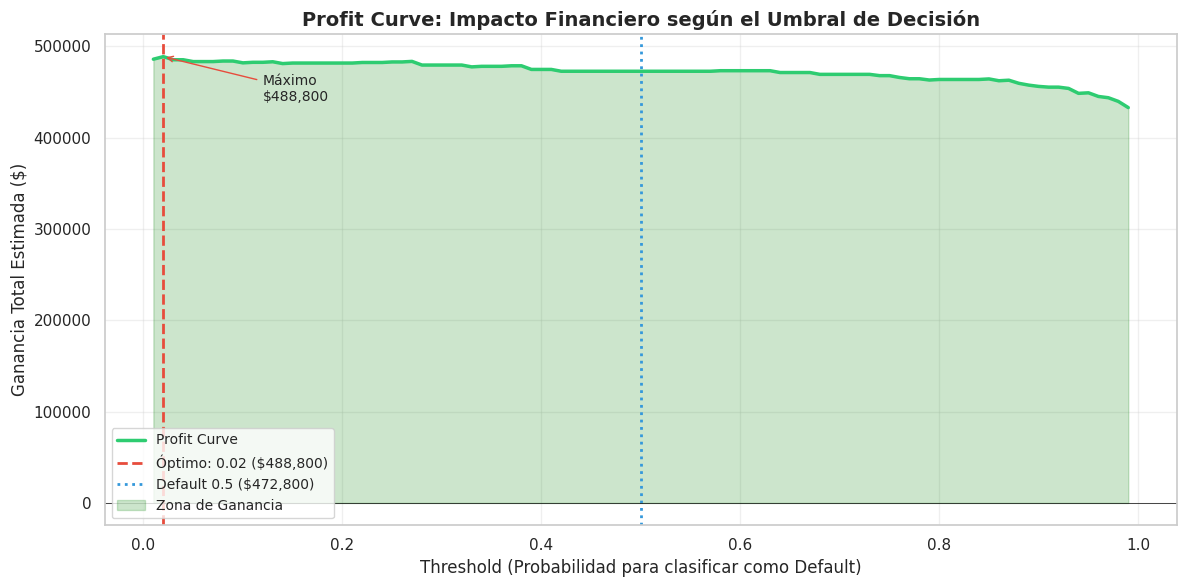

In [10]:
# Visualizar la Curva de Ganancia
fig, ax = plt.subplots(figsize=(12, 6))

# Profit curve
ax.plot(thresholds, profits, label='Profit Curve',
        color='#2ecc71', linewidth=2.5)

# Líneas de referencia
ax.axvline(best_threshold, color='#e74c3c', linestyle='--', linewidth=2,
           label=f'Óptimo: {best_threshold:.2f} (${max_profit:,.0f})')
ax.axvline(0.5, color='#3498db', linestyle=':', linewidth=2,
           label=f'Default 0.5 (${profit_default:,.0f})')
ax.axhline(0, color='black', linewidth=0.5)

# Sombrear zona de ganancia
ax.fill_between(thresholds, profits, 0, where=[p > 0 for p in profits],
                alpha=0.2, color='green', label='Zona de Ganancia')

ax.set_title('Profit Curve: Impacto Financiero según el Umbral de Decisión',
             fontsize=14, fontweight='bold')
ax.set_xlabel(
    'Threshold (Probabilidad para clasificar como Default)', fontsize=12)
ax.set_ylabel('Ganancia Total Estimada ($)', fontsize=12)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

# Anotación del punto óptimo
ax.annotate(f'Máximo\n${max_profit:,.0f}',
            xy=(best_threshold, max_profit),
            xytext=(best_threshold + 0.1, max_profit * 0.9),
            fontsize=10, ha='left',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))

plt.tight_layout()
plt.show()


### 🧠 Micro-Desafío: Impacto del Negocio
Modifica la matriz de costos en la función de ganancia.
Si un **Falso Negativo** (perder el dinero prestado) costara el doble (**$4,000** en vez de $2,000):

1.  ¿Cómo cambiaría el umbral (threshold) óptimo? ¿Debería subir o bajar?
2.  ¿Cuánto dinero dejaríamos de ganar si no ajustamos el modelo a este nuevo costo?
3.  ¿Qué pasa si el costo de FP (rechazar buen cliente) aumenta a $500?

---
## 🏆 5. Conclusión: Resumen de Logros

¡Felicidades! Has completado el ciclo completo de optimización y monetización de un modelo ML:

| Aspecto | Qué Hicimos | Por Qué Importa |
|---------|-------------|-----------------|
| **🎯 Optuna** | Optimización Bayesiana de hiperparámetros | Encontramos mejores configuraciones en minutos vs días con GridSearch |
| **⚖️ Calibración** | Verificamos que las probabilidades son confiables | Un "80%" debe significar realmente 80% de riesgo |
| **💰 Profit Curve** | Tradujimos métricas ML a impacto financiero | El umbral óptimo NO es 0.5; es el que maximiza $ |
| **🔧 Pipeline** | Preprocesamiento robusto sin data leakage | El modelo funcionará igual en producción |

### 📊 Métricas Clave de Esta Sesión
- **AUC Optimizado:** El modelo encontró la mejor configuración de LightGBM.
- **Umbral de Negocio:** Movimos el threshold del estándar 0.5 al óptimo para el P&L.
- **ROI Mejorado:** Cuantificamos la mejora en dólares, no solo en accuracy.

### 💡 Key Takeaways
1.  **GridSearch está obsoleto** para modelos con muchos hiperparámetros. Usa Optuna.
2.  **El AUC no lo es todo.** Un modelo de menor AUC puede ser más rentable.
3.  **El umbral 0.5 es arbitrario.** Siempre optimiza para el costo de negocio.
4.  **Calibración es crítica** si necesitas probabilidades precisas (pricing, provisiones).

---

👉 **Siguiente Paso:** En la próxima sesión exploraremos **Modelos Ensamblados Avanzados** (Stacking, Blending) y técnicas de **Interpretabilidad** (SHAP, LIME) para explicar al negocio por qué el modelo toma cada decisión.